In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]


### Combined tasks

In [2]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2"))
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]
    # Approximate, since timing isn't EXACTLY 300ms/1200ms
    # Add ISI to task 2 predictions to get absolute time
    df[pred_cols_t2] = df[pred_cols_t2].add(df['interval_t1'] * 250, axis=0)

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]
    return df


In [3]:
paths = [Path("files/t1_peaks.csv"), Path("files/t2_peaks.csv")]
labels = [labels_t1, labels_t2]
df = determine_order(paths, labels)

In [22]:
def plot_timing_effect_on_rt(df, event_idx, task="t1"):
    threshold = 50
    event_idx = f"event_{event_idx}_idx"

    event_counts = df.groupby(["condition", event_idx]).size().reset_index(name="count")
    valid_pairs = event_counts[event_counts["count"] > threshold]
    df = df.merge(
        valid_pairs[["condition", event_idx]],
        on=["condition", event_idx],
        how="inner",  # Keep only rows that match valid (condition, event) pairs
    )
    df[f"rt_samples_{task}"] = (df[f"rt_samples_{task}"] / 250) * 1000
    sns.violinplot(data=df, x=event_idx, y=f"rt_samples_{task}", hue="condition")
    plt.xlabel(f"Event at position {event_idx} in time")
    plt.ylabel(f"RT {task} (ms)")
    plt.show()


def plot_order_effect_on_rt(df, orders: list[list[int]], labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]):
    set_seaborn_style()
    event_cols = [col for col in df.columns if col.startswith("event_")]
    df = df.copy()
    df["order_idx"] = -1  # Initialize with -1 for rows that don't match any order
    df = df[df["condition"] == "short"]
    for idx, order in enumerate(orders):
        # Compare order of events with order in dataframe
        mask = (
            (df[event_cols[0]] == order[0])
            & (df[event_cols[1]] == order[1])
            & (df[event_cols[2]] == order[2])
            & (df[event_cols[3]] == order[3])
            & (df[event_cols[4]] == order[4])
            & (df[event_cols[5]] == order[5])
        )
        df.loc[mask, "order_idx"] = idx
    # Filter out rows with order_idx -1
    df = df[df["order_idx"] != -1]
    df["rt_samples_t1"] = (df["rt_samples_t1"] / 250) * 1000
    ax = sns.violinplot(data=df, x="order_idx", y="rt_samples_t1", cut=0)
    xticks = [' > '.join([labels[i] for i in order]) for order in orders]
    plt.xticks(range(len(orders)), xticks, rotation=45)
    plt.hlines(y=610.63, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[2], linestyles='dashed', label="Mean RT (short)")
    plt.hlines(y=599.84, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[1], linestyles='dashed', label="Mean RT (long)")
    plt.legend()
    plt.xlabel("Order of events")
    plt.ylabel("RT t1 (ms)")
    plt.ylim(200, 1000)
    plt.show()

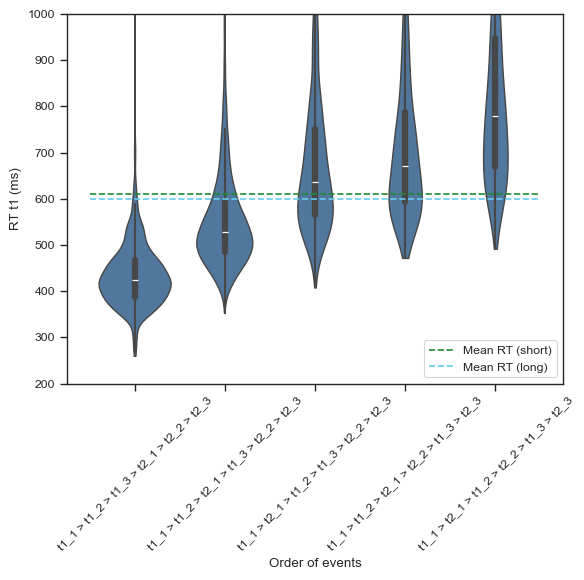

In [23]:
plot_order_effect_on_rt(df, [[0, 1, 2, 3, 4, 5], [0, 1, 3, 2, 4, 5], [0, 3, 1, 2, 4, 5], [0, 1, 3, 4, 2, 5], [0, 3, 1, 4, 2, 5]])

In [ ]:
df[df["event_3_idx"] == 4].iloc[0,:]
# t1_1 - 43, t2_1, 112, t1_2 - 150, t2_2 - 161, t1_3 - 191, t2_3 - 235
# THE event_n_idx N-TH EVENT is the INDEX IN LABELS

condition                                                       short
epoch                                                           481.0
participant                                                       VP5
rt_samples_t1                                                     196
t1_1_pred                                                        43.0
t1_1_true                                                        13.0
t1_1_peak_values    [0.8136295676231384, 0.18116751313209534, -0.1...
t1_2_pred                                                       150.0
t1_2_true                                                       158.0
t1_2_peak_values    [-2.080155372619629, -2.2829220294952393, -1.4...
t1_3_pred                                                       191.0
t1_3_true                                                       190.0
t1_3_peak_values    [-0.8969032764434814, -0.6788650155067444, -1....
rt_samples_t2                                                     180
t2_1_pred           

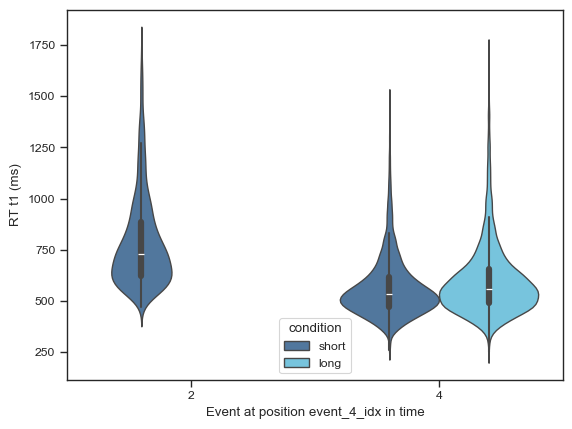

In [124]:
plot_timing_effect_on_rt(df, 4, task='t1')

In [55]:
def plot_order_distribution_stacked(df, labels, min_count=50):
    set_seaborn_style()
    # Count the occurrences of each order, grouped by condition
    order_columns = [f"event_{i}_idx" for i in range(len(labels))]
    df = df[["condition"] + order_columns]
    order_counts = (
        df.groupby(["condition"])
        .apply(lambda x: x[order_columns].apply(tuple, axis=1).value_counts())
        .reset_index(name="Count")
    )

    # Filter orders with more than min_count occurrences
    order_counts = order_counts[order_counts["Count"] > min_count]

    # Create a DataFrame for plotting
    order_df = pd.DataFrame(order_counts)
    order_df.columns = ["condition", "Order", "Count"]

    # Convert the Order tuples to strings for better readability
    order_df["Order"] = order_df["Order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Count", y="Order", hue="condition", data=order_df, dodge=False)
    plt.xlabel("Count")
    plt.ylabel("Order")
    plt.show()

/tmp/ipykernel_1301895/1020923082.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[order_columns].apply(tuple, axis=1).value_counts())


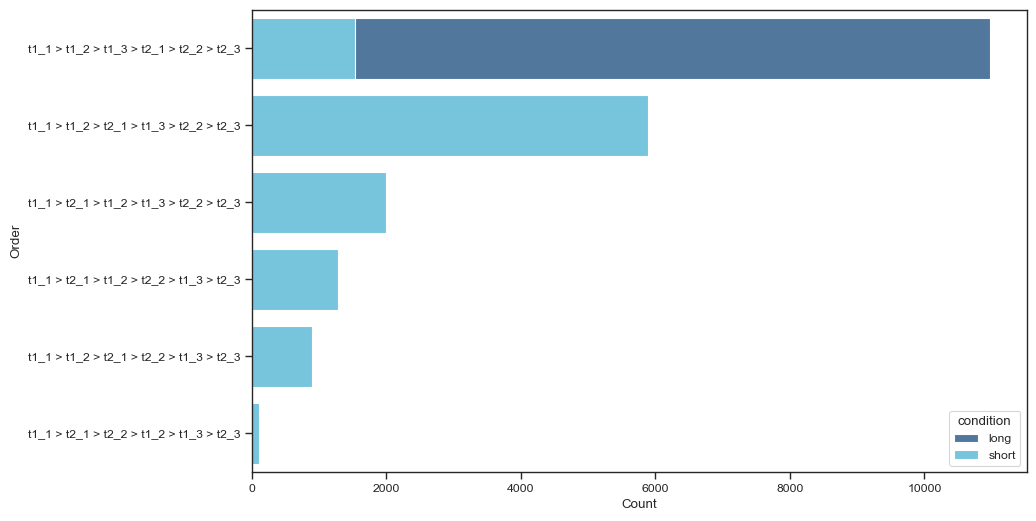

In [56]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)

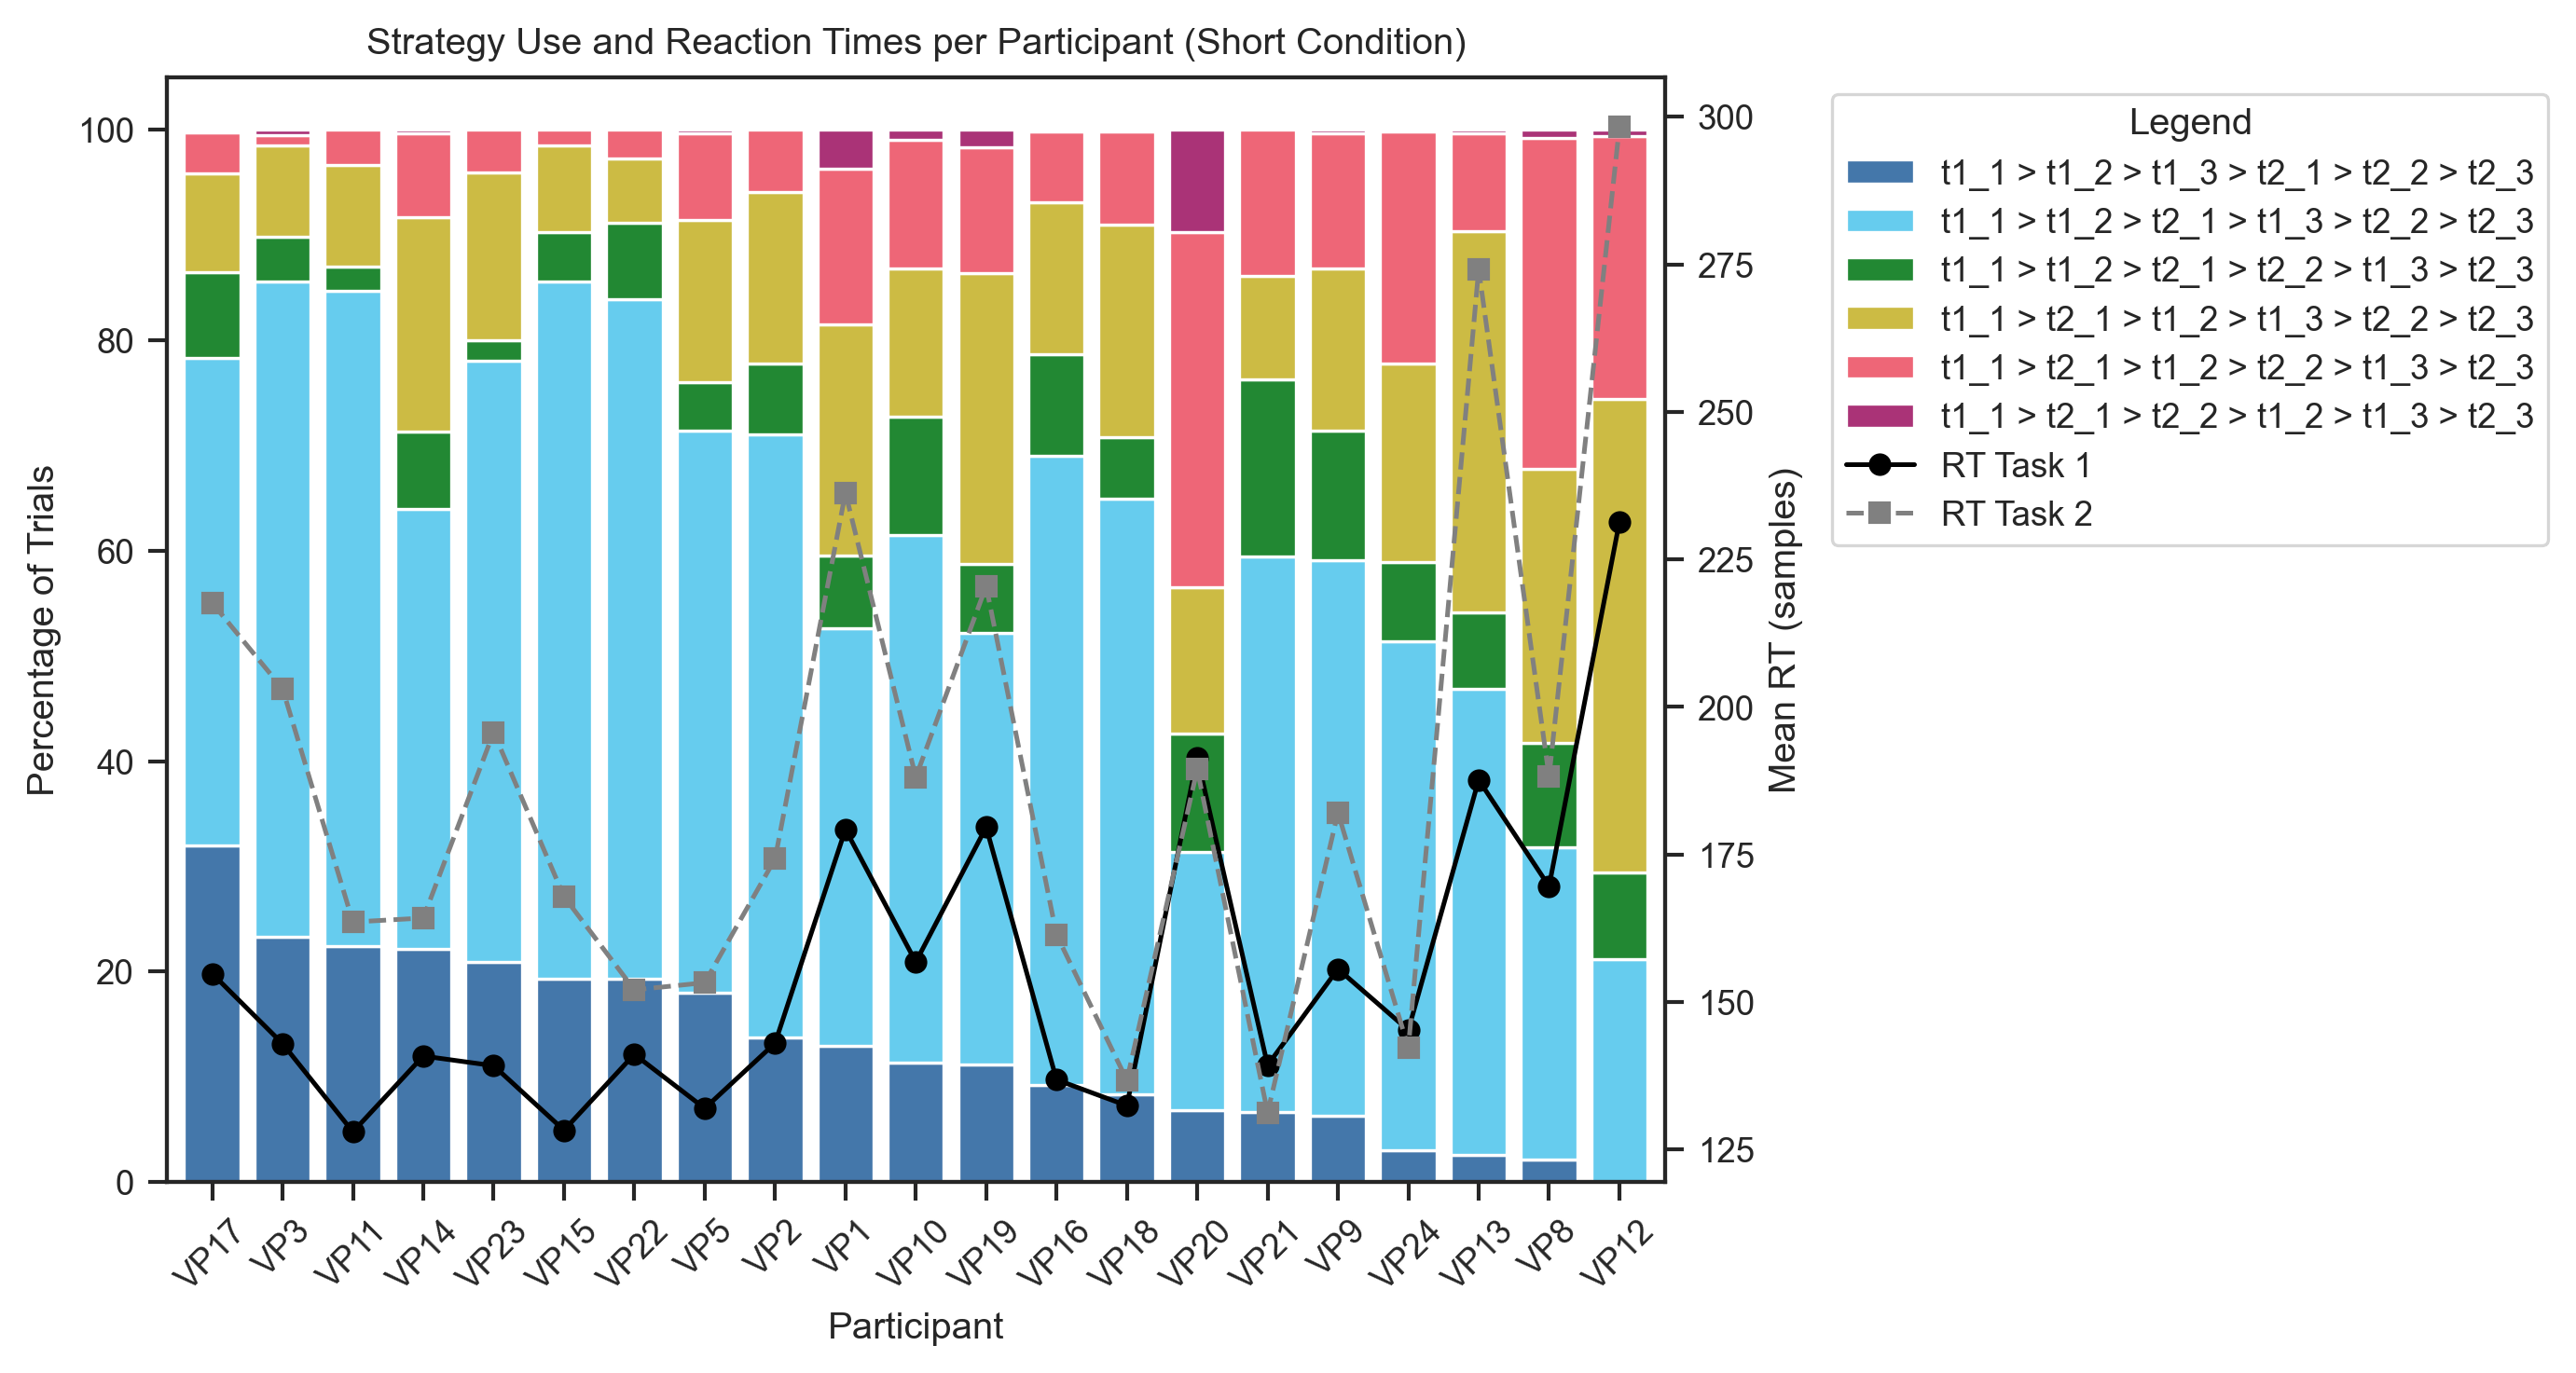

In [76]:
def plot_relative_order_with_rt_lines(df, labels, min_count=1):
    set_seaborn_style()

    if "participant" not in df.columns:
        raise ValueError("The DataFrame must contain a 'participant' column.")

    # Filter for short condition
    df_short = df[df["condition"] == "short"].copy()

    # === STRATEGY DISTRIBUTION ===
    order_columns = [f"event_{i}_idx" for i in range(len(labels))]
    df_short["Order"] = df_short[order_columns].apply(tuple, axis=1)

    order_counts = df_short.groupby(["participant", "Order"]).size().reset_index(name="Count")

    global_counts = order_counts.groupby("Order")["Count"].sum()
    valid_orders = global_counts[global_counts >= min_count].index
    order_counts = order_counts[order_counts["Order"].isin(valid_orders)]

    order_counts["Order"] = order_counts["Order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    pivot_df = order_counts.pivot_table(index="participant", columns="Order", values="Count", fill_value=0)
    percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    # Sort participants by usage of the first strategy
    first_strategy = percent_df.columns[0]
    percent_df = percent_df.sort_values(by=first_strategy, ascending=False)
    sorted_participants = percent_df.index.tolist()

    # === MEAN RTs ===
    rt_df = df_short.groupby("participant")[["rt_samples_t1", "rt_samples_t2"]].mean()
    rt_df = rt_df.loc[sorted_participants]

    # === PLOTTING ===
    fig, ax1 = plt.subplots(figsize=(9.5, 5), dpi=300)

    # Stacked bar plot
    percent_df.plot(kind="bar", stacked=True, ax=ax1, width=0.8)
    ax1.set_ylabel("Percentage of Trials")
    ax1.set_xlabel("Participant")
    ax1.set_title("Strategy Use and Reaction Times per Participant (Short Condition)")
    ax1.legend(title="Order", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Line plot on twin y-axis
    ax2 = ax1.twinx()
    ax2.plot(range(len(rt_df)), rt_df["rt_samples_t1"], marker="o", linestyle="-", color="black", label="RT Task 1")
    ax2.plot(range(len(rt_df)), rt_df["rt_samples_t2"], marker="s", linestyle="--", color="gray", label="RT Task 2")
    ax2.set_ylabel("Mean RT (samples)")

    # x-axis tick labels
    ax1.set_xticks(range(len(sorted_participants)))
    ax1.set_xticklabels(sorted_participants, rotation=45)

    # Combine legends
    bars_legend = ax1.get_legend_handles_labels()
    lines_legend = ax2.get_legend_handles_labels()
    ax1.legend(
        handles=bars_legend[0] + lines_legend[0],
        labels=bars_legend[1] + lines_legend[1],
        bbox_to_anchor=(1.10, 1),
        loc="upper left",
        title="Legend"
    )

    plt.tight_layout()
    plt.show()
plot_relative_order_with_rt_lines(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)

In [65]:
df

,condition,epoch,participant,interval_t1,rt_samples_t1,t1_1_pred,t1_1_true,t1_1_peak_values,t1_2_pred,t1_2_true,...,t2_2_peak_values,t2_3_pred,t2_3_true,t2_3_peak_values,event_0_idx,event_1_idx,event_2_idx,event_3_idx,event_4_idx,event_5_idx
0,short,1155.0,VP24,0.275391,138,28.0,16.0,"[-0.15628798305988312, 0.5866237282752991, 0.0...",67.0,70.0,...,"[-1.0781751871109009, -0.2842053174972534, 0.2...",175.847656,98.0,"[-0.10442546010017395, 0.5780912637710571, 0.4...",0,1,3,2,4,5
1,long,603.0,VP1,1.177734,107,26.0,23.0,"[1.0280579328536987, 1.916599154472351, 1.0171...",70.0,70.0,...,"[2.1561439037323, 2.6004717350006104, -0.50843...",442.433594,154.0,"[-2.6979258060455322, -1.5123848915100098, -2....",0,1,2,3,4,5
2,short,136.0,VP22,0.277344,136,21.0,19.0,"[-0.6528944969177246, -1.0654758214950562, -0....",69.0,93.0,...,"[0.34996217489242554, -0.17843957245349884, 1....",198.335938,120.0,"[-4.487628936767578, -2.3566884994506836, 1.18...",0,1,3,2,4,5
3,long,750.0,VP3,1.175781,116,48.0,11.0,"[10.861518859863281, 5.223399639129639, 5.5344...",75.0,78.0,...,"[5.260685443878174, 1.5796382427215576, 1.8355...",377.945312,84.0,"[-8.463813781738281, -3.0467796325683594, -4.2...",0,1,2,3,4,5
4,long,598.0,VP16,1.177734,120,28.0,25.0,"[-3.09013032913208, 1.1489592790603638, 2.8933...",70.0,84.0,...,"[-1.6008566617965698, -2.5074350833892822, -1....",385.433594,92.0,"[-3.0086169242858887, -1.2831604480743408, -2....",0,1,2,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22782,short,854.0,VP15,0.277344,165,34.0,28.0,"[1.166257381439209, 1.5207505226135254, 1.9727...",70.0,104.0,...,"[-0.383125901222229, -1.3770488500595093, 0.42...",208.335938,138.0,"[0.4138399660587311, 1.8338243961334229, 0.931...",0,1,3,2,4,5
22783,short,516.0,VP10,0.277344,138,27.0,21.0,"[0.4686599373817444, 1.5149372816085815, 2.266...",102.0,102.0,...,"[-6.611660003662109, -8.36766529083252, -4.712...",198.335938,122.0,"[3.5520169734954834, 1.9009732007980347, 3.441...",0,3,1,2,4,5
22784,long,576.0,VP3,1.177734,154,34.0,33.0,"[13.105460166931152, 10.43362808227539, 7.1143...",82.0,108.0,...,"[5.352581024169922, 4.799509048461914, 2.33016...",359.433594,68.0,"[0.9110196828842163, 2.847693681716919, 0.1478...",0,1,2,3,4,5
22785,short,1212.0,VP24,0.277344,248,23.0,19.0,"[-0.860765814781189, 0.7475249767303467, 0.168...",167.0,178.0,...,"[-0.251651406288147, 0.053278133273124695, 0.3...",279.335938,194.0,"[-1.0489259958267212, -1.0708963871002197, -0....",0,3,1,4,2,5


In [57]:
df

,condition,epoch,participant,interval_t1,rt_samples_t1,t1_1_pred,t1_1_true,t1_1_peak_values,t1_2_pred,t1_2_true,...,t2_2_peak_values,t2_3_pred,t2_3_true,t2_3_peak_values,event_0_idx,event_1_idx,event_2_idx,event_3_idx,event_4_idx,event_5_idx
0,short,1155.0,VP24,0.275391,138,28.0,16.0,"[-0.15628798305988312, 0.5866237282752991, 0.0...",67.0,70.0,...,"[-1.0781751871109009, -0.2842053174972534, 0.2...",175.847656,98.0,"[-0.10442546010017395, 0.5780912637710571, 0.4...",0,1,3,2,4,5
1,long,603.0,VP1,1.177734,107,26.0,23.0,"[1.0280579328536987, 1.916599154472351, 1.0171...",70.0,70.0,...,"[2.1561439037323, 2.6004717350006104, -0.50843...",442.433594,154.0,"[-2.6979258060455322, -1.5123848915100098, -2....",0,1,2,3,4,5
2,short,136.0,VP22,0.277344,136,21.0,19.0,"[-0.6528944969177246, -1.0654758214950562, -0....",69.0,93.0,...,"[0.34996217489242554, -0.17843957245349884, 1....",198.335938,120.0,"[-4.487628936767578, -2.3566884994506836, 1.18...",0,1,3,2,4,5
3,long,750.0,VP3,1.175781,116,48.0,11.0,"[10.861518859863281, 5.223399639129639, 5.5344...",75.0,78.0,...,"[5.260685443878174, 1.5796382427215576, 1.8355...",377.945312,84.0,"[-8.463813781738281, -3.0467796325683594, -4.2...",0,1,2,3,4,5
4,long,598.0,VP16,1.177734,120,28.0,25.0,"[-3.09013032913208, 1.1489592790603638, 2.8933...",70.0,84.0,...,"[-1.6008566617965698, -2.5074350833892822, -1....",385.433594,92.0,"[-3.0086169242858887, -1.2831604480743408, -2....",0,1,2,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22782,short,854.0,VP15,0.277344,165,34.0,28.0,"[1.166257381439209, 1.5207505226135254, 1.9727...",70.0,104.0,...,"[-0.383125901222229, -1.3770488500595093, 0.42...",208.335938,138.0,"[0.4138399660587311, 1.8338243961334229, 0.931...",0,1,3,2,4,5
22783,short,516.0,VP10,0.277344,138,27.0,21.0,"[0.4686599373817444, 1.5149372816085815, 2.266...",102.0,102.0,...,"[-6.611660003662109, -8.36766529083252, -4.712...",198.335938,122.0,"[3.5520169734954834, 1.9009732007980347, 3.441...",0,3,1,2,4,5
22784,long,576.0,VP3,1.177734,154,34.0,33.0,"[13.105460166931152, 10.43362808227539, 7.1143...",82.0,108.0,...,"[5.352581024169922, 4.799509048461914, 2.33016...",359.433594,68.0,"[0.9110196828842163, 2.847693681716919, 0.1478...",0,1,2,3,4,5
22785,short,1212.0,VP24,0.277344,248,23.0,19.0,"[-0.860765814781189, 0.7475249767303467, 0.168...",167.0,178.0,...,"[-0.251651406288147, 0.053278133273124695, 0.3...",279.335938,194.0,"[-1.0489259958267212, -1.0708963871002197, -0....",0,3,1,4,2,5


In [353]:
def get_inter_event_timings(
    df: pd.DataFrame,
    event_1: str,
    event_2: str,
    event_disruptor: str = None,
    labels: list[str] = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"],
    condition: str = None,
    return_df: bool = False,
):
    # Calculate the time difference between two events
    if condition is not None:
        df = df[df["condition"] == condition]
    ev1_label = f"{event_1}_pred"
    ev2_label = f"{event_2}_pred"

    event_cols = [col for col in df.columns if col.startswith("event_")]
    event_sequences = df[event_cols].values.tolist()

    if event_disruptor is not None:
        target_sequence = [
            labels.index(event_1),
            labels.index(event_disruptor),
            labels.index(event_2),
        ]
        mask = [
            any(
                sequence[i : i + len(target_sequence)] == target_sequence
                for i in range(len(sequence) - len(target_sequence) + 1)
            )
            for sequence in event_sequences
        ]
        df = df[mask]
    else:
        # We know that the order is t1_1, t1_2, t1_3, t2_1, t2_2, t2_3
        # Only use timings between those two events (that are always sequential)
        # When the order is 'default'
        df = df[
            (df[event_cols[0]] == 0)
            & (df[event_cols[1]] == 1)
            & (df[event_cols[2]] == 2)
            & (df[event_cols[3]] == 3)
            & (df[event_cols[4]] == 4)
            & (df[event_cols[5]] == 5)
        ]

    if return_df:
        return df
    else:
        diffs = df[ev2_label] - df[ev1_label]
        df = df[["condition", "epoch", "participant"]]
        df["difference"] = (diffs / 250) * 1000  # Convert to milliseconds
        df["disrupted"] = 1 if event_disruptor is not None else 0
        return df

In [270]:
def plot_inter_event_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition='short')
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    df = pd.concat([no_disruption, with_disruption])
    sns.violinplot(data=df, x="disrupted", y="difference", split=False)
    plt.xticks([0, 1], ['Not disrupted', f'Disrupted by {event_disruptor}'])
    plt.ylabel(f"Time between {event_1} and {event_2} (samples)")
    # plt.xlabel(f"Time between {event_1} and {event_2} (samples)")
    plt.show()

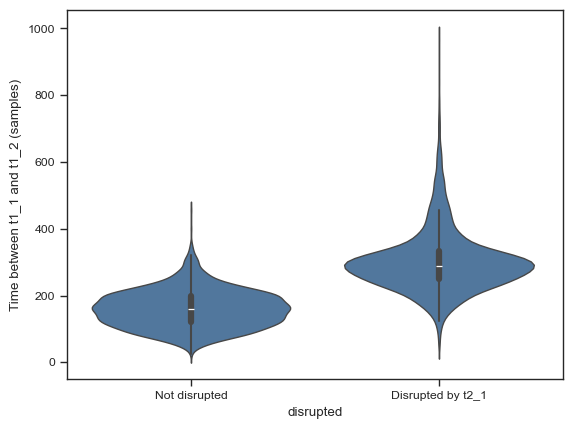

In [337]:
plot_inter_event_timings(df, "t1_1", "t1_2", "t2_1")

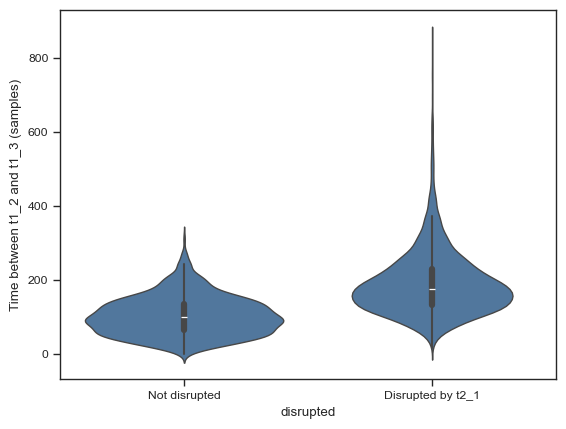

In [338]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_1")

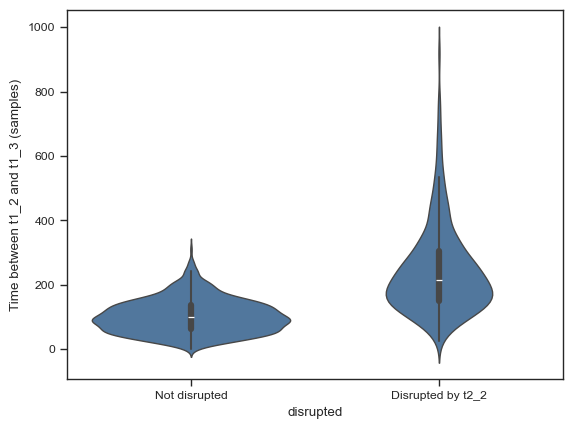

In [339]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_2")

In [ ]:
def get_disruptor_timings(df, event_1, event_2, event_disruptor, source='long', labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]):
    # How long event_1 > event_2 usually takes
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    
    # How long event_1 > event_2 takes when event_disruptor is present
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')

    # How long event_disruptor > next event usually takes 
    after_disruption = get_inter_event_timings(df, event_disruptor, labels[labels.index(event_disruptor) + 1], condition="long")
    after_disruption["disrupted"] = 2

    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption, after_disruption])
    return df

def plot_all_timings():
    results = []
    for event_1, event_2 in [
        ("t1_1", "t1_2"),
        ("t1_2", "t1_3"),
        ("t2_1", "t2_2"),
        ("t2_2", "t2_3"),
        # ("t1_3", "t2_1"),	
    ]:
        for source in ["long", "short"]:
            combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
            combination_results["sequence"] = f"{event_1} > {event_2}"
            results.append(combination_results)
    results = pd.concat(results)
    return results

In [ ]:
results = []
for event_1, event_2 in [
    ("t1_1", "t1_2"),
    ("t1_2", "t1_3"),
    ("t2_1", "t2_2"),
    ("t2_2", "t2_3"),
    ("t1_3", "t2_1"),	
]:
    for source in ["long", "short"]:
        combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
        combination_results["sequence"] = f"{event_1} > {event_2}"
        results.append(combination_results)
results = pd.concat(results)

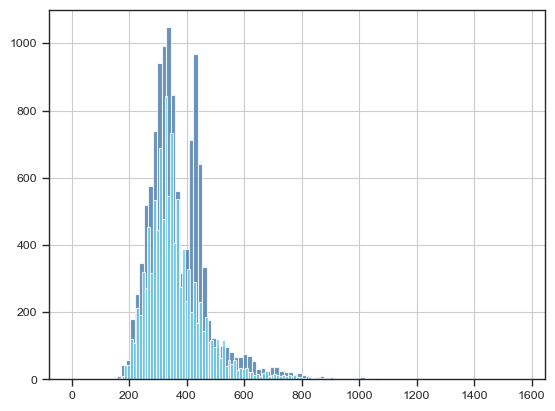

In [335]:
((df[df['condition'] == 'short']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8)
((df[df['condition'] == 'long']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8)
plt.show()

Disrupted sequences vs non-disrupted sequences, per unique disruption, uses only SHORT timings from default order

Found 3491 disruptions (cases where t1_1 > t2_1 > t1_2)
Found 5373 disruptions (cases where t1_2 > t2_1 > t1_3)
Found 1306 disruptions (cases where t1_2 > t2_2 > t1_3)
Found 5382 disruptions (cases where t2_1 > t1_3 > t2_2)
Found 2280 disruptions (cases where t2_2 > t1_3 > t2_3)


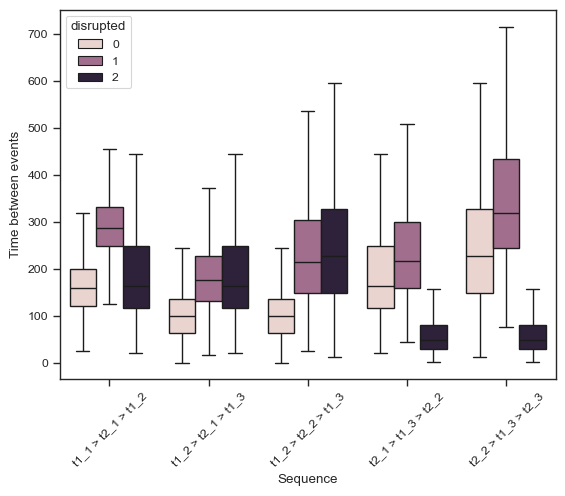

In [381]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    ("t1_2", "t1_3", "t2_1"),
    ("t1_2", "t1_3", "t2_2"),
    ("t2_1", "t2_2", "t1_3"),
    ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short")
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [383]:
for sequence in results["sequence"].unique():
    sequence_df = results[results["sequence"] == sequence]
    disr_0 = sequence_df[sequence_df["disrupted"] == 0]["difference"]
    disr_1 = sequence_df[sequence_df["disrupted"] == 1]["difference"]
    disr_2 = sequence_df[sequence_df["disrupted"] == 2]["difference"]

    n_boot = 10000
    boot_diffs = []
    for _ in range(n_boot):
        boot_0 = np.random.choice(disr_0, size=len(disr_0), replace=True).mean()
        boot_1 = np.random.choice(disr_1, size=len(disr_1), replace=True).mean()
        boot_2 = np.random.choice(disr_2, size=len(disr_2), replace=True).mean()
        diff = boot_2 - (boot_1 - boot_0)
        boot_diffs.append(diff)

    lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
    print(f"{sequence} 95% CI: [{lower:.2f}, {upper:.2f}]")
# How much bigger the difference between disruptor > next is than the difference between event 1 > event 2 with and without disruptor

t1_1 > t2_1 > t1_2 95% CI: [44.07, 57.13]
t1_2 > t2_1 > t1_3 95% CI: [98.76, 111.20]
t1_2 > t2_2 > t1_3 95% CI: [101.85, 122.57]
t2_1 > t1_3 > t2_2 95% CI: [2.55, 15.58]
t2_2 > t1_3 > t2_3 95% CI: [-46.34, -27.45]


In [ ]:
# If (t1_1 > t2_1 > t1_2), want to also know if increase is similar to t2_1 > t2_2
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    ("t1_2", "t1_3", "t2_1"),
    ("t1_2", "t1_3", "t2_2"),
    ("t2_1", "t2_2", "t1_3"),
    ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short")
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.violinplot(results, x="sequence", y="difference", hue="disrupted", cut=0)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

,condition,epoch,participant,difference,disrupted,sequence
2,short,49.0,VP14,156.0,False,t1_1 > t2_1 > t1_2
22,short,425.0,VP10,164.0,False,t1_1 > t2_1 > t1_2
30,short,849.0,VP17,220.0,False,t1_1 > t2_1 > t1_2
47,short,772.0,VP1,152.0,False,t1_1 > t2_1 > t1_2
52,short,1017.0,VP10,112.0,False,t1_1 > t2_1 > t1_2
...,...,...,...,...,...,...
22827,short,1032.0,VP12,268.0,True,t2_2 > t1_3 > t2_3
22828,short,946.0,VP19,516.0,True,t2_2 > t1_3 > t2_3
22831,short,1164.0,VP13,672.0,True,t2_2 > t1_3 > t2_3
22866,short,886.0,VP22,332.0,True,t2_2 > t1_3 > t2_3


In [ ]:
from contextlib import redirect_stdout
import io, warnings

def model_inter_event_timings(df, event_1, event_2, event_disruptor, source='long'):
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    no_disruption['condition'] = 'long'
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption])
    df["disrupted"] = df["condition"] == 'short'
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = "difference ~ disrupted + (1|participant)"
    model = Lmer(formula, data=df)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with redirect_stdout(io.StringIO()):
            model.fit(verbose=False)

    # print(model.summary())
    return model

In [ ]:
def plot_modelled_inter_event_timings():
    results = []
    for event_1, event_2, event_disruptor in [
        ("t1_1", "t1_2", "t2_1"),
        ("t1_2", "t1_3", "t2_1"),
        ("t1_2", "t1_3", "t2_2"),
        ("t2_1", "t2_2", "t1_3"),
        ("t2_2", "t2_3", "t1_3"),
    ]:
        for source in ["long", "short", None]:
            model = model_inter_event_timings(
                df, event_1, event_2, event_disruptor, source=source
            )
            disruptor_effect = model.coefs["Estimate"].iloc[1].item()
            disruptor_effect_SE = model.coefs["SE"].iloc[1].item()
            combination_results = {
                "sequence": " > ".join([event_1, event_disruptor, event_2]),
                "source": source,
                "disruptor_effect": disruptor_effect,
                "disruptor_SE": disruptor_effect_SE,
            }
            results.append(combination_results)

    results = pd.DataFrame(results)
    results["source"] = results["source"].fillna("combined")
    set_seaborn_style()
    sns.lineplot(results, x="source", y="disruptor_effect", hue="sequence")
    plt.title("Inter-Event Timing (IET) disruption")
    plt.ylabel("Effect of disruption (ms) on IET")
    plt.xlabel("Source of valid IET")
    plt.xticks(rotation=45)
    plt.ylim(0, 200)
    plt.show()

In [ ]:
plot_modelled_inter_event_timings()

In [ ]:
# get_inter_event_timings(df, 't1_1', 't1_2', event_disruptor='t2_1', condition='short')['difference'].hist()
sns.violinplot(x=0, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='short')['difference'])
sns.violinplot(x=1, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='long')['difference'])

In [ ]:
model = model_inter_event_timings(df, "t1_1", "t1_2", "t2_1")